In [2]:
import pandas as pd
import yfinance as yf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import torch
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scikeras.wrappers import KerasRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Load the file
stock_name = "PG"
file_path = f"stock_datasets/{stock_name}.xlsx"
if file_path.endswith('.csv'):
    news_df = pd.read_csv(file_path)
elif file_path.endswith('.xlsx'):
    news_df = pd.read_excel(file_path)
else:
    raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")

# Remove rows where the 'Time' column has invalid dates
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # Convert invalid dates to NaT
news_df = news_df.dropna(subset=['Time'])  # Drop rows with NaT in 'Time'

# Display the cleaned DataFrame
print(news_df)

                                         absolute href  \
0    https://www.investing.com/news/stock-market-ne...   
1    https://www.investing.com/news/press-releases/...   
2    https://www.investing.com/news/stock-market-ne...   
3    https://www.investing.com/news/stock-market-ne...   
4    https://www.investing.com/news/pro/procter--ga...   
..                                                 ...   
983  https://www.investing.com/news/stock-market-ne...   
984  https://www.investing.com/news/stock-market-ne...   
985  https://www.investing.com/news/stock-market-ne...   
986  https://www.investing.com/news/stock-market-ne...   
987  https://www.investing.com/news/stock-market-ne...   

                                                 Title  \
0    Seeing low-income consumers squeezed, retailer...   
1    P&G to Webcast Discussion of Second Quarter 20...   
2    Exclusive-Procter & Gamble to disclose more de...   
3    P&G agrees to disclose more on wood-pulp suppl...   
4    Procter 

In [4]:
# Sort the DataFrame by 'Time'
news_df_sorted = news_df.sort_values(by='Time')

# Remove duplicate rows and select only 'Title' and 'Time' columns
news_df_cleaned = news_df_sorted[['Title', 'Time']].drop_duplicates()

# Rename the 'Time' column to 'Date'
news_df_cleaned = news_df_cleaned.rename(columns={'Time': 'Date'})

# Optionally, reset the index after removing duplicates
news_df_cleaned = news_df_cleaned.reset_index(drop=True)

# Save the cleaned data as JSON
news_df_cleaned.to_json(f"news_title/{stock_name}_news_title.json", orient='records', lines=True)

# Display the cleaned DataFrame
news_df_cleaned.head()


,Title,Date
0,Day Ahead: Top 3 Things to Watch,2019-04-25
1,U.S. stocks higher at close of trade; Dow Jone...,2019-04-26
2,U.S. stocks higher at close of trade; Dow Jone...,2019-04-29
3,U.S. stocks higher at close of trade; Dow Jone...,2019-05-10
4,U.S. stocks lower at close of trade; Dow Jones...,2019-05-13


In [5]:
# Determine the start and end dates from the news data
start_date = news_df_cleaned['Date'].min().strftime('%Y-%m-%d')
end_date = news_df_cleaned['Date'].max().strftime('%Y-%m-%d')

# Download historical data for AstraZeneca (AZN) based on the date range from the news data
stock_data = yf.download(stock_name, start=start_date, end=end_date)

# Display the first few rows of the data
print(stock_data.head())
print(stock_data.tail())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close  Adj Close   Volume
Date                                                                          
2019-04-25  103.099998  103.570000  102.589996  103.279999  90.125175  6085300
2019-04-26  103.949997  105.879997  103.910004  105.860001  92.376549  7747400
2019-04-29  105.570000  105.750000  104.720001  104.779999  91.434128  4787600
2019-04-30  104.860001  106.620003  104.660004  106.480003  92.917603  8251300
2019-05-01  106.150002  106.389999  104.809998  104.930000  91.565002  6733800
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-12-12  171.429993  171.820007  170.020004  170.850006  170.850006   
2024-12-13  170.770004  171.789993  170.119995  171.059998  171.059998   
2024-12-16  171.449997  172.779999  171.100006  171.139999  171.139999   
2024-12-17  170.669998  171.949997  170.020004  170.330002  170.330002   
202

In [6]:
modelName = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForSequenceClassification.from_pretrained(modelName)
def calculateDailySentiment(headlines):
    texts = [headline['heading'] for headline in headlines]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512, return_attention_mask=True)
    outputs = model(**inputs)
    logits = outputs.logits
    scores = logits.softmax(dim=1)
    averageScore = scores.mean(dim=0).tolist()
    return averageScore


def analyzeAndSaveSentiment(inputFile, outputFile):
    result = {}
    
    # Open the file and process each line as a separate JSON object
    with open(inputFile, 'r',  encoding="utf8") as file:
        for line in file:
            # Parse each line (record) as a separate JSON object
            record = json.loads(line)
            date = record.get('Date')
            title = record.get('Title')

            if date and title:
                # Convert the timestamp to a readable date
                readable_date = datetime.fromtimestamp(int(date) / 1000).strftime('%Y-%m-%d')
                
                # Prepare the headlines in the required format
                headlines = [{'heading': title}]
                averageScore = calculateDailySentiment(headlines)
                print(f"{readable_date} > {averageScore}")
                result[readable_date] = averageScore


    with open(outputFile, 'w', encoding="utf8") as outFile:
        json.dump(result, outFile, indent=2)


In [7]:
inputJsonFile = f"news_title/{stock_name}_news_title.json"
outputJsonFile = f"sentiment_score/{stock_name}_news_sentiment_score.json"

analyzeAndSaveSentiment(inputJsonFile, outputJsonFile)

2019-04-25 > [0.003968367353081703, 0.003822759725153446, 0.026315633207559586, 0.13521142303943634, 0.8306818008422852]
2019-04-26 > [0.28012606501579285, 0.3678226172924042, 0.259503036737442, 0.059071559458971024, 0.033476755023002625]
2019-04-29 > [0.28800588846206665, 0.3641359806060791, 0.25471583008766174, 0.05973188951611519, 0.033410437405109406]
2019-05-10 > [0.28072768449783325, 0.36716538667678833, 0.2587015628814697, 0.05940903350710869, 0.03399619460105896]
2019-05-13 > [0.30611273646354675, 0.42960238456726074, 0.2193557322025299, 0.031732238829135895, 0.013196899555623531]
2019-05-14 > [0.27926748991012573, 0.3653048276901245, 0.2627250850200653, 0.05953218787908554, 0.033170390874147415]
2019-05-21 > [0.2863670587539673, 0.366433322429657, 0.2581537961959839, 0.05711916461586952, 0.031926654279232025]
2019-05-28 > [0.35623881220817566, 0.4062742292881012, 0.19598422944545746, 0.02906089276075363, 0.012441789731383324]
2019-06-05 > [0.27926748991012573, 0.36530482769012

2019-11-13 > [0.46942585706710815, 0.24324645102024078, 0.16534292697906494, 0.07438258081674576, 0.04760216549038887]
2019-11-18 > [0.2608047425746918, 0.15532933175563812, 0.170410618185997, 0.18835178017616272, 0.225103497505188]
2019-11-21 > [0.19888634979724884, 0.28900855779647827, 0.33056753873825073, 0.11889373511075974, 0.062643863260746]
2019-11-21 > [0.3478773832321167, 0.412549763917923, 0.19713479280471802, 0.029716316610574722, 0.01272170152515173]
2019-11-21 > [0.2999437153339386, 0.13694113492965698, 0.17250369489192963, 0.18000385165214539, 0.2106076329946518]
2019-11-26 > [0.28215059638023376, 0.37089481949806213, 0.25532737374305725, 0.05838659778237343, 0.03324061259627342]
2019-12-02 > [0.16877855360507965, 0.27169498801231384, 0.31184130907058716, 0.16345161199569702, 0.08423358201980591]
2019-12-02 > [0.36000239849090576, 0.404910147190094, 0.19363750517368317, 0.028954654932022095, 0.012495334260165691]
2019-12-03 > [0.3133678436279297, 0.42144542932510376, 0.21

2020-06-04 > [0.27458319067955017, 0.39288464188575745, 0.2553408443927765, 0.05647815018892288, 0.020713213831186295]
2020-06-11 > [0.31386861205101013, 0.4190223217010498, 0.21850532293319702, 0.03391919285058975, 0.014684644527733326]
2020-06-18 > [0.2712417244911194, 0.4166148602962494, 0.25346651673316956, 0.044363606721162796, 0.014313237741589546]
2020-06-19 > [0.48774027824401855, 0.19730129837989807, 0.14453810453414917, 0.08011079579591751, 0.09030945599079132]
2020-06-19 > [0.11944981664419174, 0.14934608340263367, 0.282817006111145, 0.25261789560317993, 0.19576917588710785]
2020-06-24 > [0.3043503165245056, 0.43125325441360474, 0.2200692743062973, 0.031438812613487244, 0.012888362631201744]
2020-06-25 > [0.4383087456226349, 0.24941252171993256, 0.17827729880809784, 0.07922836393117905, 0.05477302521467209]
2020-07-07 > [0.31803324818611145, 0.42060884833335876, 0.21432949602603912, 0.03285492584109306, 0.014173397794365883]
2020-07-15 > [0.28466981649398804, 0.3678078651428

2021-03-30 > [0.34935489296913147, 0.4089665710926056, 0.1987755000591278, 0.03004242107272148, 0.012860587798058987]
2021-04-01 > [0.28020310401916504, 0.36456385254859924, 0.2614898085594177, 0.06005236878991127, 0.03369088098406792]
2021-04-13 > [0.1725013256072998, 0.1426820158958435, 0.1554991900920868, 0.22658079862594604, 0.30273663997650146]
2021-04-18 > [0.002862389199435711, 0.0020968576427549124, 0.006111323833465576, 0.044756580144166946, 0.9441729187965393]
2021-04-19 > [0.03544913977384567, 0.03368978202342987, 0.1292715221643448, 0.30322667956352234, 0.49836283922195435]
2021-04-20 > [0.1388629674911499, 0.14672349393367767, 0.1991485357284546, 0.25774139165878296, 0.2575235962867737]
2021-04-20 > [0.579890251159668, 0.25403428077697754, 0.11672291904687881, 0.029109854251146317, 0.02024264633655548]
2021-04-20 > [0.21874605119228363, 0.45613420009613037, 0.2787293493747711, 0.036898382008075714, 0.009491962380707264]
2021-04-20 > [0.08822506666183472, 0.3102955222129822

2021-10-22 > [0.3670893609523773, 0.3806077539920807, 0.17775720357894897, 0.051314931362867355, 0.023230789229273796]
2021-10-26 > [0.28800588846206665, 0.3641359806060791, 0.25471583008766174, 0.05973188951611519, 0.033410437405109406]
2021-10-26 > [0.42883044481277466, 0.21886968612670898, 0.1554325670003891, 0.11497309803962708, 0.08189424872398376]
2021-10-27 > [0.013287806883454323, 0.01791127398610115, 0.06150110065937042, 0.3315795361995697, 0.5757202506065369]
2021-10-27 > [0.028643827885389328, 0.046659983694553375, 0.13785408437252045, 0.35109472274780273, 0.435747355222702]
2021-11-02 > [0.40648049116134644, 0.2332952320575714, 0.1417263001203537, 0.11345696449279785, 0.10504089295864105]
2021-11-12 > [0.0551166795194149, 0.058001916855573654, 0.1599643975496292, 0.30784329771995544, 0.4190737307071686]
2021-11-12 > [0.22256889939308167, 0.1956985741853714, 0.1524907648563385, 0.19477903842926025, 0.2344626635313034]
2021-11-17 > [0.14115646481513977, 0.1252717673778534, 0.

2022-04-20 > [0.42888084053993225, 0.27208736538887024, 0.16096210479736328, 0.06532075256109238, 0.07274892926216125]
2022-04-20 > [0.15773135423660278, 0.12193906307220459, 0.14399361610412598, 0.21579524874687195, 0.3605407476425171]
2022-04-20 > [0.23554003238677979, 0.2453080415725708, 0.22798943519592285, 0.1778966337442398, 0.11326580494642258]
2022-04-21 > [0.028882671147584915, 0.03154937922954559, 0.08660073578357697, 0.28540751338005066, 0.5675596594810486]
2022-04-22 > [0.1510632038116455, 0.24863982200622559, 0.3509399890899658, 0.18857011198997498, 0.060786809772253036]
2022-04-22 > [0.05519041791558266, 0.05502123758196831, 0.12459027767181396, 0.2763049900531769, 0.4888931214809418]
2022-04-22 > [0.30023765563964844, 0.4297664165496826, 0.22438864409923553, 0.032399702817201614, 0.013207566924393177]
2022-04-23 > [0.6201983094215393, 0.2190190851688385, 0.08910677582025528, 0.038751427084207535, 0.03292436525225639]
2022-04-24 > [0.021976422518491745, 0.0211994498968124

2022-08-10 > [0.030090654268860817, 0.04458347707986832, 0.15766595304012299, 0.3945491313934326, 0.37311074137687683]
2022-08-17 > [0.032362278550863266, 0.029964543879032135, 0.08938692510128021, 0.29872822761535645, 0.5495580434799194]
2022-08-17 > [0.022946655750274658, 0.022498514503240585, 0.08604515343904495, 0.33597758412361145, 0.5325320959091187]
2022-08-17 > [0.6196110844612122, 0.24256420135498047, 0.0938989520072937, 0.024886013939976692, 0.019039878621697426]
2022-08-22 > [0.18716765940189362, 0.18002572655677795, 0.22025293111801147, 0.21118806302547455, 0.2013656049966812]
2022-09-04 > [0.3604904115200043, 0.24764108657836914, 0.1559886634349823, 0.1225961446762085, 0.1132836788892746]
2022-09-06 > [0.7339199185371399, 0.14022548496723175, 0.062227703630924225, 0.03242667391896248, 0.031200222671031952]
2022-09-19 > [0.4120568633079529, 0.23093479871749878, 0.1928785741329193, 0.10927677899599075, 0.05485306680202484]
2022-09-27 > [0.7138140201568604, 0.1897828429937362

2023-01-16 > [0.01149598229676485, 0.011217058636248112, 0.029324259608983994, 0.1435793936252594, 0.8043833374977112]
2023-01-18 > [0.16691449284553528, 0.0925736203789711, 0.15351255238056183, 0.20968638360500336, 0.37731292843818665]
2023-01-18 > [0.036334551870822906, 0.12872643768787384, 0.43286582827568054, 0.3036544919013977, 0.09841866046190262]
2023-01-19 > [0.45143187046051025, 0.2732951045036316, 0.17531441152095795, 0.057713620364665985, 0.04224500060081482]
2023-01-19 > [0.2240704447031021, 0.2845620810985565, 0.24631302058696747, 0.14194194972515106, 0.10311248898506165]
2023-01-19 > [0.3331928551197052, 0.4818412661552429, 0.1632850021123886, 0.01622162200510502, 0.005459161475300789]
2023-01-19 > [0.15354065597057343, 0.1943117082118988, 0.2560455799102783, 0.20597711205482483, 0.19012503325939178]
2023-01-19 > [0.46839311718940735, 0.3413427770137787, 0.14834316074848175, 0.030177241191267967, 0.01174375880509615]
2023-01-19 > [0.6612455248832703, 0.22433257102966309, 

2023-04-21 > [0.6013307571411133, 0.25041601061820984, 0.10895951092243195, 0.02343895472586155, 0.015854759141802788]
2023-04-21 > [0.5697653293609619, 0.24295242130756378, 0.11771232634782791, 0.03672807291150093, 0.032841961830854416]
2023-04-21 > [0.5255982875823975, 0.3011869788169861, 0.11651233583688736, 0.034711748361587524, 0.021990716457366943]
2023-04-21 > [0.1478959321975708, 0.10656236857175827, 0.15489833056926727, 0.22860278189182281, 0.36204057931900024]
2023-04-24 > [0.28186848759651184, 0.2924880385398865, 0.25585418939590454, 0.1151779368519783, 0.054611384868621826]
2023-04-24 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2023-04-25 > [0.09591823071241379, 0.09797292202711105, 0.1601552814245224, 0.2759564220905304, 0.3699971139431]
2023-04-26 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2023-05-02 > [0.6878035068511963, 0.20209801197052002, 0.052

2023-10-18 > [0.3998257517814636, 0.3130592703819275, 0.19132530689239502, 0.05863826721906662, 0.03715134039521217]
2023-10-18 > [0.34254148602485657, 0.3282288908958435, 0.224869042634964, 0.06911539286375046, 0.03524524345993996]
2023-10-18 > [0.07914111018180847, 0.07178661227226257, 0.12854835391044617, 0.28371164202690125, 0.43681231141090393]
2023-10-18 > [0.005062244366854429, 0.007276629097759724, 0.040786340832710266, 0.3086438775062561, 0.6382309198379517]
2023-10-18 > [0.5689697861671448, 0.22082875669002533, 0.13332271575927734, 0.04722065106034279, 0.02965809404850006]
2023-10-18 > [0.20883749425411224, 0.24757030606269836, 0.25292322039604187, 0.17282947897911072, 0.11783942580223083]
2023-10-18 > [0.5461321473121643, 0.25098171830177307, 0.12585195899009705, 0.04111739993095398, 0.035916801542043686]
2023-10-18 > [0.16878242790699005, 0.2003793567419052, 0.2855558395385742, 0.20208314061164856, 0.14319919049739838]
2023-10-18 > [0.1436941921710968, 0.16818538308143616, 

2024-03-07 > [0.09616833925247192, 0.09407887607812881, 0.1984100192785263, 0.3173370659351349, 0.29400569200515747]
2024-03-08 > [0.014432583004236221, 0.0157460980117321, 0.03955288603901863, 0.27272987365722656, 0.6575385332107544]
2024-03-11 > [0.15553981065750122, 0.15889225900173187, 0.20299921929836273, 0.24521416425704956, 0.23735450208187103]
2024-03-11 > [0.06406654417514801, 0.09620244055986404, 0.15837515890598297, 0.31689587235450745, 0.36445993185043335]
2024-03-11 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2024-03-11 > [0.29392296075820923, 0.31221911311149597, 0.21129871904850006, 0.11779845505952835, 0.06476074457168579]
2024-03-13 > [0.030636657029390335, 0.028954418376088142, 0.06947890669107437, 0.3053038716316223, 0.5656260848045349]
2024-03-17 > [0.020696936175227165, 0.02525457926094532, 0.11437350511550903, 0.42406508326530457, 0.41560983657836914]
2024-03-17 > [0.10299777239561081, 0.085150703787803

2024-05-21 > [0.007479637395590544, 0.010191460140049458, 0.05072345584630966, 0.3365284502506256, 0.5950769186019897]
2024-05-21 > [0.36650997400283813, 0.14701111614704132, 0.12606295943260193, 0.1225181519985199, 0.23789770901203156]
2024-05-28 > [0.16556794941425323, 0.10948140174150467, 0.1696552038192749, 0.26325321197509766, 0.29204219579696655]
2024-05-29 > [0.2704085409641266, 0.15680833160877228, 0.23712851107120514, 0.19973953068256378, 0.1359151303768158]
2024-06-06 > [0.20803961157798767, 0.11432322859764099, 0.16321268677711487, 0.23521018028259277, 0.27921435236930847]
2024-06-13 > [0.008071435615420341, 0.008470024913549423, 0.04757288470864296, 0.33149561285972595, 0.6043900847434998]
2024-06-24 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2024-06-24 > [0.02882792428135872, 0.035048868507146835, 0.11334022879600525, 0.35996153950691223, 0.4628213942050934]
2024-06-27 > [0.09006629139184952, 0.0729721933603286

2024-09-10 > [0.19879791140556335, 0.08995907008647919, 0.10494935512542725, 0.14643877744674683, 0.4598548710346222]
2024-09-10 > [0.240131676197052, 0.15844595432281494, 0.18123333156108856, 0.20698340237140656, 0.2132057100534439]
2024-09-16 > [0.06521445512771606, 0.05890962854027748, 0.12120186537504196, 0.28815019130706787, 0.46652382612228394]
2024-09-16 > [0.2672240436077118, 0.34550905227661133, 0.2603996694087982, 0.09216267615556717, 0.0347045473754406]
2024-09-16 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2024-09-18 > [0.017827564850449562, 0.031889159232378006, 0.11839331686496735, 0.42694148421287537, 0.40494850277900696]
2024-09-19 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2024-09-20 > [0.30449149012565613, 0.19651900231838226, 0.2184232771396637, 0.17504477500915527, 0.10552137345075607]
2024-09-23 > [0.32565057277679443, 0.29893428087234497, 0.

2024-11-22 > [0.6743450164794922, 0.22737202048301697, 0.07449766248464584, 0.01443610992282629, 0.009349139407277107]
2024-11-25 > [0.3268852233886719, 0.1625257432460785, 0.22158074378967285, 0.16532495617866516, 0.12368328124284744]
2024-11-25 > [0.013259120285511017, 0.013802900910377502, 0.03346811607480049, 0.21936100721359253, 0.7201088070869446]
2024-11-25 > [0.05539175122976303, 0.06388186663389206, 0.14496886730194092, 0.32025450468063354, 0.41550302505493164]
2024-11-25 > [0.3574178218841553, 0.1391591578722, 0.1272280216217041, 0.1320565938949585, 0.24413840472698212]
2024-11-26 > [0.13044242560863495, 0.10303325206041336, 0.17628949880599976, 0.2852557897567749, 0.3049790859222412]
2024-11-27 > [0.012284471653401852, 0.011374992318451405, 0.06610595434904099, 0.30465584993362427, 0.6055787801742554]
2024-12-02 > [0.5156837701797485, 0.1666325032711029, 0.12621928751468658, 0.08618944883346558, 0.10527510195970535]
2024-12-03 > [0.2721811532974243, 0.41367632150650024, 0.25

In [8]:
# Load the sentiment scores from the JSON file
with open(f"sentiment_score/{stock_name}_news_sentiment_score.json", 'r') as f:
    sentiment_data = json.load(f)

# Create a DataFrame to store the sentiment scores without averaging them
processed_data = {
    'Date': [],
    'SentimentScores': []
}

# Iterate through the JSON data and append the sentiment scores for each date
for date, scores in sentiment_data.items():
    processed_data['Date'].append(date)
    processed_data['SentimentScores'].append(scores)  # Keep the list of sentiment scores

# Convert processed data to a DataFrame
news_sentiment_df = pd.DataFrame(processed_data)

# Ensure the 'Date' column is in datetime format
news_sentiment_df['Date'] = pd.to_datetime(news_sentiment_df['Date'])

# Display the DataFrame
news_sentiment_df


,Date,SentimentScores
0,2019-04-25,"[0.003968367353081703, 0.003822759725153446, 0..."
1,2019-04-26,"[0.28012606501579285, 0.3678226172924042, 0.25..."
2,2019-04-29,"[0.28800588846206665, 0.3641359806060791, 0.25..."
3,2019-05-10,"[0.28072768449783325, 0.36716538667678833, 0.2..."
4,2019-05-13,"[0.30611273646354675, 0.42960238456726074, 0.2..."
...,...,...
515,2024-12-03,"[0.025919809937477112, 0.021797344088554382, 0..."
516,2024-12-05,"[0.1651548147201538, 0.11443816125392914, 0.17..."
517,2024-12-16,"[0.2783403992652893, 0.1617664098739624, 0.181..."
518,2024-12-18,"[0.28383997082710266, 0.17530909180641174, 0.2..."


In [9]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-25,103.099998,103.570000,102.589996,103.279999,90.125175,6085300
2019-04-26,103.949997,105.879997,103.910004,105.860001,92.376549,7747400
2019-04-29,105.570000,105.750000,104.720001,104.779999,91.434128,4787600
2019-04-30,104.860001,106.620003,104.660004,106.480003,92.917603,8251300
2019-05-01,106.150002,106.389999,104.809998,104.930000,91.565002,6733800
...,...,...,...,...,...,...
2024-12-12,171.429993,171.820007,170.020004,170.850006,170.850006,4072800
2024-12-13,170.770004,171.789993,170.119995,171.059998,171.059998,3884500
2024-12-16,171.449997,172.779999,171.100006,171.139999,171.139999,5943600


In [10]:
news_sentiment_df.head()

,Date,SentimentScores
0,2019-04-25,"[0.003968367353081703, 0.003822759725153446, 0..."
1,2019-04-26,"[0.28012606501579285, 0.3678226172924042, 0.25..."
2,2019-04-29,"[0.28800588846206665, 0.3641359806060791, 0.25..."
3,2019-05-10,"[0.28072768449783325, 0.36716538667678833, 0.2..."
4,2019-05-13,"[0.30611273646354675, 0.42960238456726074, 0.2..."


In [11]:
# Merge the two DataFrames on the 'Date' column
dfMerged = pd.merge(stock_data, news_sentiment_df, on='Date', how='left')

# Check if each element in 'SentimentScores' is a list, and replace invalid ones with NaN or an empty list
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if isinstance(x, list) else [None] * 5)

# Ensure each list in 'SentimentScores' has 5 elements (or adjust this if your data varies)
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if len(x) == 5 else [None] * 5)

# Convert the 'SentimentScores' list into separate columns
dfSentimentColumns = pd.DataFrame(dfMerged['SentimentScores'].tolist(), columns=['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])

# Concatenate the origi|nal DataFrame with the new sentiment columns
dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)

# Drop unnecessary columns
dfMerged = dfMerged.drop(columns=['SentimentScores'])

# Display the merged DataFrame
dfMerged.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Very negative,Negative,Neutral,Positive,Very Positive
0,2019-04-25,103.099998,103.570000,102.589996,103.279999,90.125175,6085300,0.003968,0.003823,0.026316,0.135211,0.830682
1,2019-04-26,103.949997,105.879997,103.910004,105.860001,92.376549,7747400,0.280126,0.367823,0.259503,0.059072,0.033477
2,2019-04-29,105.570000,105.750000,104.720001,104.779999,91.434128,4787600,0.288006,0.364136,0.254716,0.059732,0.033410
3,2019-04-30,104.860001,106.620003,104.660004,106.480003,92.917603,8251300,NaN,NaN,NaN,NaN,NaN
4,2019-05-01,106.150002,106.389999,104.809998,104.930000,91.565002,6733800,NaN,NaN,NaN,NaN,NaN


In [12]:
dfMerged[['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']] = dfMerged[['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']].interpolate(method='linear', axis=0)
dfMerged

,Date,Open,High,Low,Close,Adj Close,Volume,Very negative,Negative,Neutral,Positive,Very Positive
0,2019-04-25,103.099998,103.570000,102.589996,103.279999,90.125175,6085300,0.003968,0.003823,0.026316,0.135211,0.830682
1,2019-04-26,103.949997,105.879997,103.910004,105.860001,92.376549,7747400,0.280126,0.367823,0.259503,0.059072,0.033477
2,2019-04-29,105.570000,105.750000,104.720001,104.779999,91.434128,4787600,0.288006,0.364136,0.254716,0.059732,0.033410
3,2019-04-30,104.860001,106.620003,104.660004,106.480003,92.917603,8251300,0.287197,0.364473,0.255159,0.059696,0.033476
4,2019-05-01,106.150002,106.389999,104.809998,104.930000,91.565002,6733800,0.286389,0.364809,0.255602,0.059660,0.033541
...,...,...,...,...,...,...,...,...,...,...,...,...
1419,2024-12-12,171.429993,171.820007,170.020004,170.850006,170.850006,4072800,0.246002,0.148244,0.180082,0.214844,0.210828
1420,2024-12-13,170.770004,171.789993,170.119995,171.059998,171.059998,3884500,0.262171,0.155005,0.180757,0.204557,0.197510
1421,2024-12-16,171.449997,172.779999,171.100006,171.139999,171.139999,5943600,0.278340,0.161766,0.181432,0.194269,0.184192
1422,2024-12-17,170.669998,171.949997,170.020004,170.330002,170.330002,6069200,0.281090,0.168538,0.200227,0.190955,0.159190


Missing values:
Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Very negative    0
Negative         0
Neutral          0
Positive         0
Very Positive    0
dtype: int64
Statistical summary:
              Open         High          Low        Close    Adj Close  \
count  1424.000000  1424.000000  1424.000000  1424.000000  1424.000000   
mean    141.784073   142.924087   140.745435   141.854242   133.069620   
std      16.997714    16.952645    16.990115    16.997183    20.703730   
min     100.190002   103.570000    94.339996    97.699997    86.869209   
25%     128.934998   129.762505   127.737499   128.547497   117.665836   
50%     142.834999   143.974998   141.754997   142.764999   133.537636   
75%     153.777504   154.855003   152.462505   153.872498   147.484253   
max     180.000000   180.429993   178.729996   179.699997   179.699997   

             Volume  Very negative     Negative      Ne

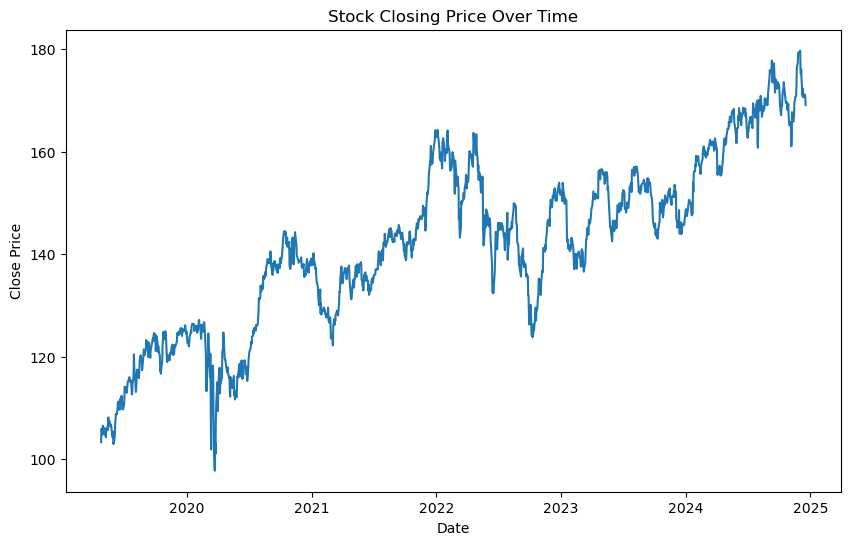

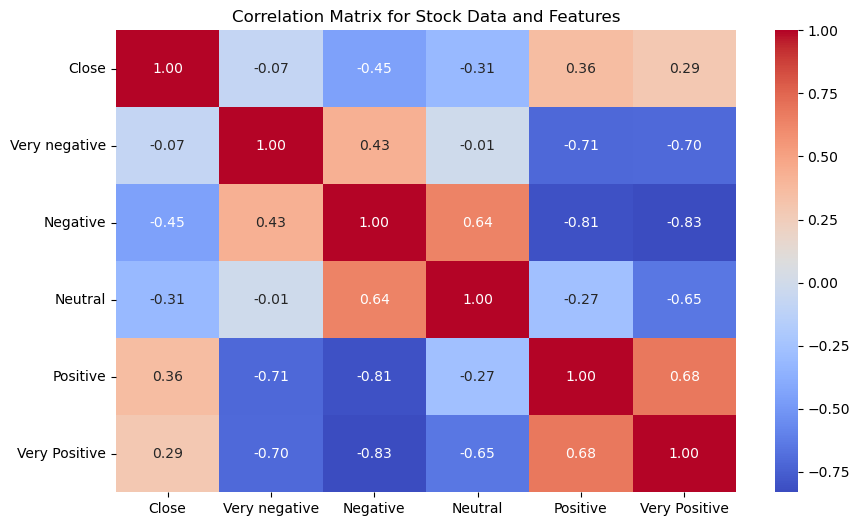

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (Assuming the dataset is already in a DataFrame 'df')
dfMerged['Date'] = pd.to_datetime(dfMerged['Date'])  # Ensure 'Date' is in datetime format

# 1. Check for missing values
print("Missing values:")
print(dfMerged.isnull().sum())

# 2. Statistical summary of numerical columns
print("Statistical summary:")
print(dfMerged.describe())


# 4. Time Series Analysis: Plot stock prices over time (e.g., 'Close' price)
plt.figure(figsize=(10, 6))
plt.plot(dfMerged['Date'], dfMerged['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# 5. Correlation Matrix (Stock Features & Additional Features)
plt.figure(figsize=(10, 6))
correlation_matrix = dfMerged[['Close', 'Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Stock Data and Features')
plt.show()

# 6. Handle Missing Values (if you choose to fill or drop)
df_cleaned = dfMerged.dropna(subset=['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])  # Drop rows with NaNs in features
# Alternatively, you can fill NaN with a specific value or interpolation (e.g., df['feature1'].fillna(df['feature1'].mean(), inplace=True))



In [14]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)

features = dfMerged.drop(['Date', 'Close'], axis=1).values
target = dfMerged['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 60
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

print(testSize)

[[[0.03646155 0.         0.0977604  ... 0.04155019 0.25036642 0.86181303]
  [0.04711182 0.03005462 0.11340215 ... 0.50623174 0.09325467 0.03196457]
  [0.06741007 0.02836326 0.12300041 ... 0.49669209 0.09461724 0.03189553]
  ...
  [0.19471246 0.16549574 0.25346614 ... 0.49403736 0.15953282 0.05904131]
  [0.18468861 0.15873013 0.24232735 ... 0.49614467 0.14336797 0.05261587]
  [0.19183057 0.16107206 0.2449343  ... 0.49825197 0.12720312 0.04619042]]

 [[0.04711182 0.03005462 0.11340215 ... 0.50623174 0.09325467 0.03196457]
  [0.06741007 0.02836326 0.12300041 ... 0.49669209 0.09461724 0.03189553]
  [0.05851395 0.03968258 0.12228946 ... 0.49757459 0.09454322 0.03196328]
  ...
  [0.18468861 0.15873013 0.24232735 ... 0.49614467 0.14336797 0.05261587]
  [0.19183057 0.16107206 0.2449343  ... 0.49825197 0.12720312 0.04619042]
  [0.1860669  0.15456672 0.23983891 ... 0.50035928 0.11103827 0.03976498]]]
[[0.21463422]
 [0.19695124]]
273


In [15]:
batchSize = 8
epoch = 88
neurons = 135
dropout = 0.15

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
#model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 135)        │        78,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 135)        │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 135)            │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 135)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,656 (1.42 MB)

 Trainable params: 371,656 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0429 - val_loss: 0.0215
Epoch 2/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0077 - val_loss: 0.0018
Epoch 3/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 4/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 6/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 7/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 8/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 9/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0029 - val_loss: 9.5118e-04
Epoch 10/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 11/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0022 - val_loss: 9.3879e-04
Epoch 12/88
109/109 ━━━━━━━━━━━━━

109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0012 - val_loss: 7.0473e-04
Epoch 68/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0013 - val_loss: 7.6476e-04
Epoch 69/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0011 - val_loss: 6.7334e-04
Epoch 70/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0012 - val_loss: 5.0237e-04
Epoch 71/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0013 - val_loss: 6.1833e-04
Epoch 72/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0011 - val_loss: 8.0333e-04
Epoch 73/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 74/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0013 - val_loss: 5.1540e-04
Epoch 75/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0012 - val_loss: 5.3771e-04
Epoch 76/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0011 - val_loss: 5.1955e-04
Epoch 77/88
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0011 - val_loss: 5.1450e-04
Epoc

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [17]:
trainY

array([[0.21463422],
       [0.19695124],
       [0.18170734],
       ...,
       [0.66365851],
       [0.65512197],
       [0.67231713]])

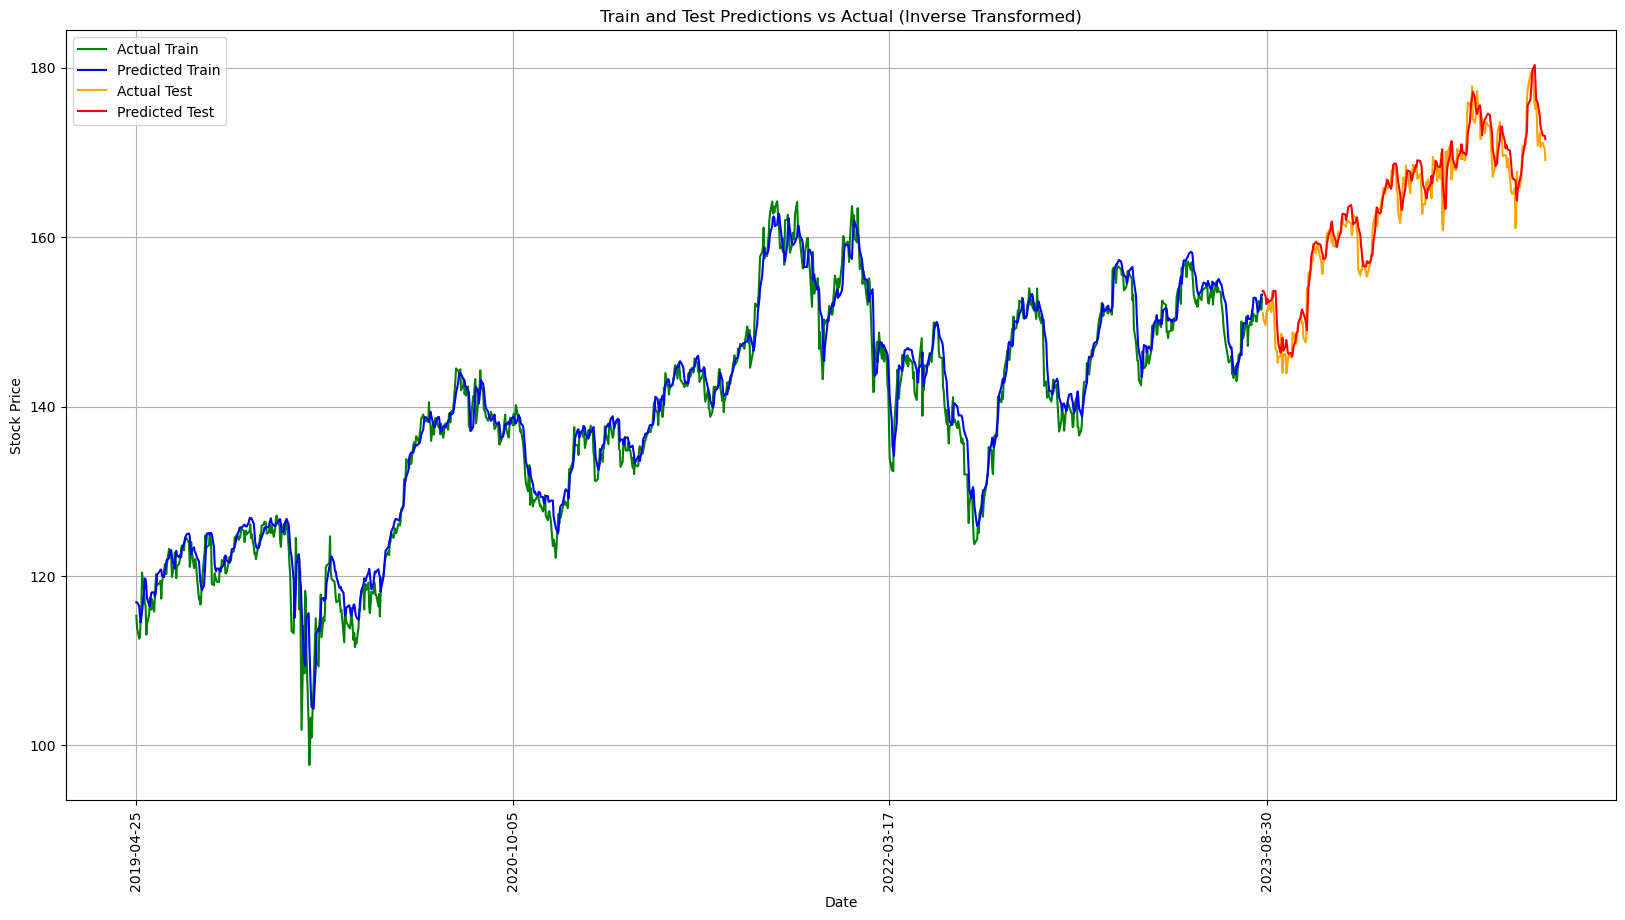

In [18]:
# Dates
dates = dfMerged['Date'].values
sampleInterval = 365  # Interval for sampled x-ticks
sampledDates = dates[::sampleInterval]

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainYInv)], trainYInv, label='Actual Train', color='green')
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train', color='blue')

plt.plot(dates[len(trainYInv):len(trainYInv) + len(testYInv)], testYInv, label='Actual Test', color='orange')
plt.plot(dates[len(trainYInv):len(trainYInv) + len(testPredictInv)], testPredictInv, label='Predicted Test', color='red')

# X-ticks
plt.xticks(sampledDates, rotation=90)

# Add labels and legend
plt.title('Train and Test Predictions vs Actual (Inverse Transformed)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Shape of Test Residuals: (273,)
Test Residuals (first 10): [-2.55311584 -3.37420654 -3.37889099 -1.07319641 -0.95922852 -1.45549011
 -0.0398407  -1.42126465  0.76382446 -0.22117615]


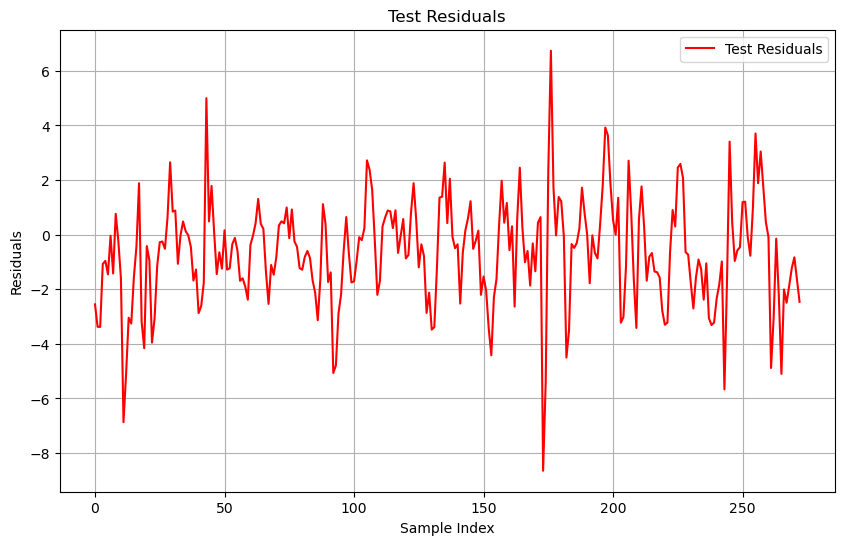

In [29]:
lstm_predictions = testPredictInv[:, 0]

testY = testYInv[:, 0] 

residuals = testY - lstm_predictions

print("Shape of Test Residuals:", residuals.shape)
print("Test Residuals (first 10):", residuals[:10])

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Test Residuals', color='red')
plt.title('Test Residuals')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\will\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


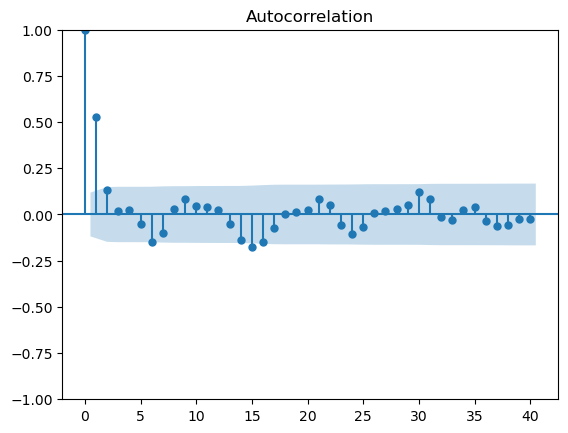

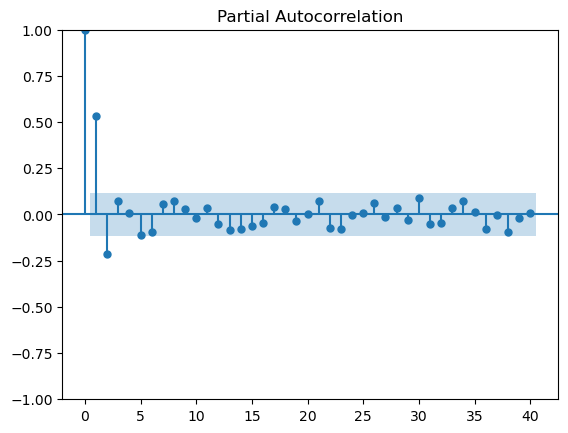

In [30]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF to identify AR and MA orders
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

In [31]:
import pmdarima as pm
import numpy as np
# Assuming residuals are univariate, ensure they are in 1D
residuals = residuals.reshape(-1)  # Flatten if necessary

# Fit auto_arima model to search over a very large range
auto_arima_model = pm.auto_arima(residuals, 
                                 p=range(0, 100),    # Search for p values from 0 to 100 (or more)
                                 d=None,             # Let auto_arima detect the order of differencing (d)
                                 q=range(0, 100),    # Search for q values from 0 to 100 (or more)
                                 seasonal=False,
                                 stepwise=True,     
                                 trace=True,         # Show output of model fitting process
                                 error_action='ignore',  # Ignore if an order does not fit
                                 suppress_warnings=True,  # Suppress warnings for cleaner output
                                 maxiter=30)     

# Summary of the chosen ARIMA model
print(auto_arima_model.summary())

# Forecast residuals for the length of the test set
arima_residual_predictions = auto_arima_model.predict(n_periods=len(testY))

# Check the predicted residuals
print(arima_residual_predictions.shape)
print(arima_residual_predictions[:5])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1055.019, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1169.161, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1059.314, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1063.917, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1053.208, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1051.786, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1053.471, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1051.208, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1053.208, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1053.118, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1041.322, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1047.517, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1052.078, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1042.891, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept

In [32]:
# Fit ARIMA model to the residuals
import statsmodels.api as sm
arima_model = sm.tsa.arima.ARIMA(residuals, order=(0,0,0))  # Adjust order as needed
arima_fitted = arima_model.fit()

# Predict residuals using ARIMA
arima_residual_predictions = arima_fitted.forecast(steps=len(testX))

In [33]:
hybrid_predictions = lstm_predictions + arima_residual_predictions


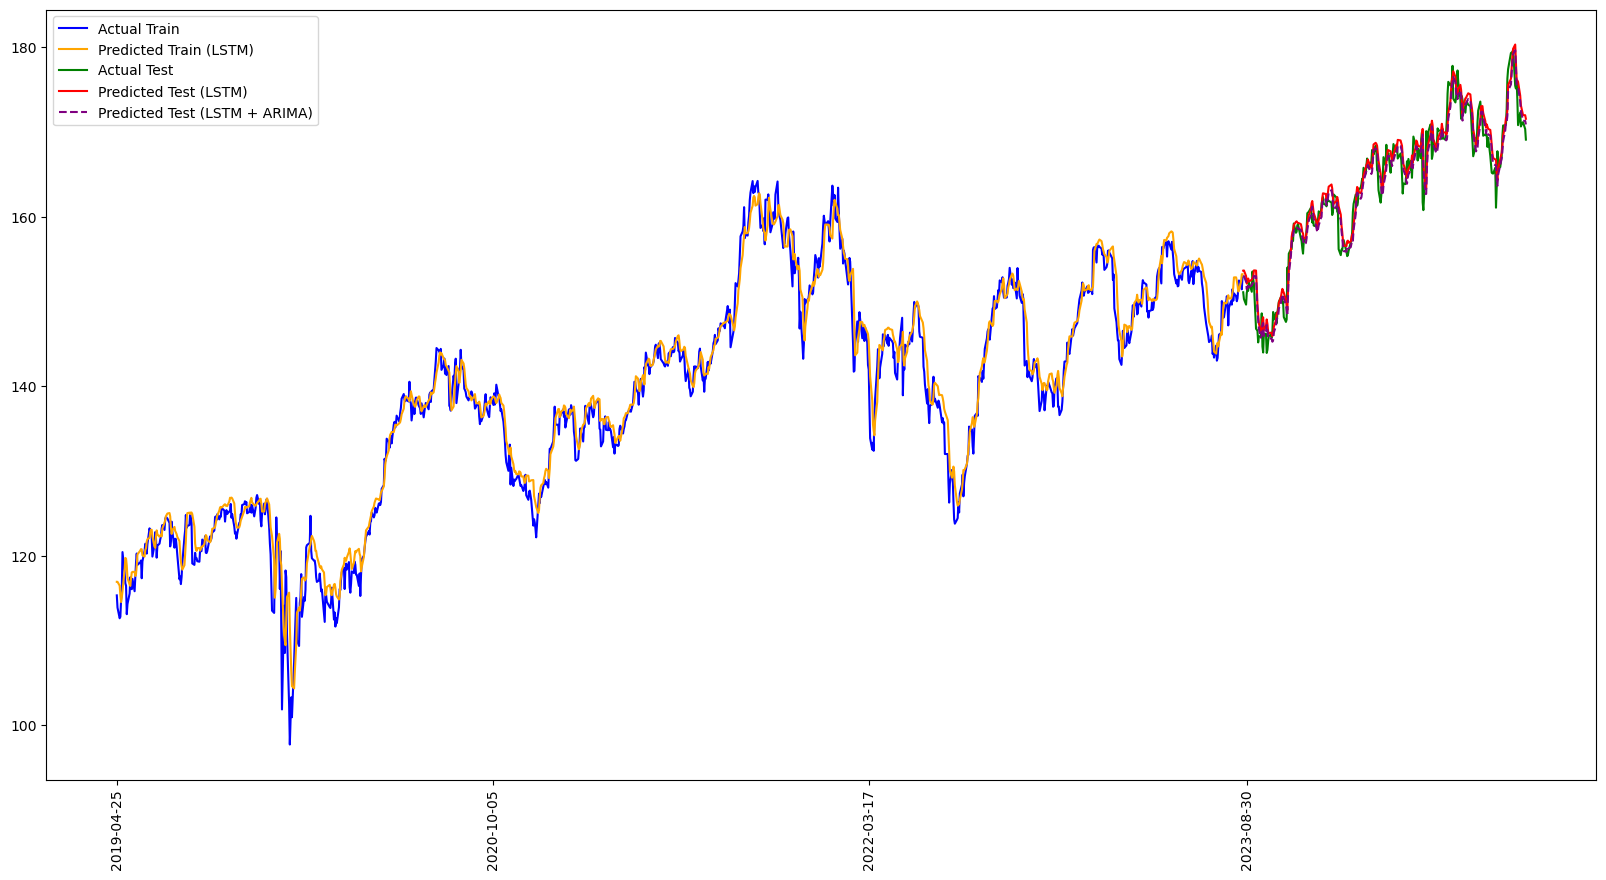

In [34]:

# Extract the dates (already available in your dataframe)
dates = dfMerged['Date'].values

# Sample interval for x-axis
sampleInterval = 365
sampledDates = dates[::sampleInterval]

# Create the plot
plt.figure(figsize=(20, 10))

# Plot actual training values
plt.plot(dates[:len(trainY)], trainYInv, label='Actual Train', color='blue')

# Plot predicted training values (LSTM only)
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train (LSTM)', color='orange')

# Plot actual test values
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testYInv, label='Actual Test', color='green')

# Plot predicted test values (LSTM only)
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(testPredictInv)], testPredictInv, label='Predicted Test (LSTM)', color='red')

# Plot predicted test values (LSTM-ARIMA hybrid)
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(hybrid_predictions)], 
         hybrid_predictions, label='Predicted Test (LSTM + ARIMA)', color='purple', linestyle='--')

# Set xticks for the sampled dates
plt.xticks(sampledDates, rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()


In [35]:




# Generate hybrid model predictions for training data
hybrid_train_predictions = lstm_predictions

# Calculate metrics for LSTM-only model
mse_lstm = mean_squared_error(testYInv, testPredictInv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(testYInv, testPredictInv)
r2_lstm = r2_score(testYInv, testPredictInv)
mape_lstm = mean_absolute_percentage_error(testYInv, testPredictInv)

# Calculate metrics for LSTM-ARIMA hybrid model
mse_hybrid = mean_squared_error(testYInv, hybrid_predictions)
rmse_hybrid = np.sqrt(mse_hybrid)
mae_hybrid = mean_absolute_error(testYInv, hybrid_predictions)
r2_hybrid = r2_score(testYInv, hybrid_predictions)
mape_hybrid = mean_absolute_percentage_error(testYInv, hybrid_predictions)

# Print the results for LSTM-only model
print(f"LSTM-Only Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.5f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.5f}")
print(f"R-squared (R²): {r2_lstm:.5f}")
print(f"Testing Accuracy: {100 - (rmse_lstm / np.mean(testYInv) * 100):.2f}%\n")

# Print the results for LSTM-ARIMA hybrid model
print(f"LSTM-ARIMA Hybrid Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_hybrid:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hybrid:.5f}")
print(f"Mean Absolute Error (MAE): {mae_hybrid:.5f}")
print(f"R-squared (R²): {r2_hybrid:.5f}")
print(f"Testing Accuracy: {100 - (rmse_hybrid / np.mean(testYInv) * 100):.2f}%")


LSTM-Only Model Evaluation Metrics:
Mean Squared Error (MSE): 4.20989
Root Mean Squared Error (RMSE): 2.05180
Mean Absolute Error (MAE): 1.53950
R-squared (R²): 0.94157
Testing Accuracy: 98.74%

LSTM-ARIMA Hybrid Model Evaluation Metrics:
Mean Squared Error (MSE): 3.76309
Root Mean Squared Error (RMSE): 1.93987
Mean Absolute Error (MAE): 1.45904
R-squared (R²): 0.94777
Testing Accuracy: 98.81%


In [36]:


# Ensure the index of stock_data is converted to datetime if not already done
stock_data.index = pd.to_datetime(stock_data.index)

# Reset the index of stock_data to turn 'Date' into a regular column
stock_data = stock_data.reset_index()

# Create a custom business day offset that excludes weekends and US federal holidays
us_business_day = CustomBusinessDay(calendar=USFederalHolidayCalendar())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Assume start_date is the first date in the test set
start_date = stock_data['Date'].iloc[-testSize]  # Assuming `stock_data` contains the full dataset with a 'Date' column

# Generate predicted dates excluding weekends and US federal holidays
predicted_dates = pd.date_range(start=start_date, periods=len(hybrid_predictions), freq=us_business_day)

# Create a DataFrame to save predictions
predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted': hybrid_predictions
})

# Save predictions to the 'predictions' directory
predictions_file_path = f"predictions/{stock_name}_hybrid_predictions.csv"
predictions_df.to_csv(predictions_file_path, index=False)

print(f"Predictions saved to '{predictions_file_path}'")


Predictions saved to 'predictions/PG_hybrid_predictions.csv'


In [37]:
# Create a dictionary with the results
results_dict = {

    "LSTM-ARIMA Hybrid Model": {
        "MSE": mse_hybrid,
        "RMSE": rmse_hybrid,
        "MAE": mae_hybrid,
        "R-squared (R²)": r2_hybrid,
        "Testing Accuracy (%)": 100 - (rmse_hybrid / np.mean(testYInv) * 100)
    }
}

# Generate the file name based on the stock name
file_name = f"model_evaluation/{stock_name}_model_evaluation.json"

# Save the results as a JSON file with the dynamic name
with open(file_name, "w") as f:
    json.dump(results_dict, f, indent=4)

print(f"Results saved as {file_name}")

Results saved as model_evaluation/PG_model_evaluation.json


In [28]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop

# Function to build the LSTM model
def create_model(neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=RMSprop())
    return model

# Objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    neurons = trial.suggest_int('neurons', 50, 150)          # Range for neurons
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
    batch_size = trial.suggest_int('batch_size', 8, 64)      # Range for batch size
    epochs = trial.suggest_int('epochs', 20, 100)            # Range for epochs

    # Create and train the model
    model = create_model(neurons, dropout)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # Return validation loss as the metric to minimize
    val_loss = min(history.history['val_loss'])
    return val_loss

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters found
best_params = study.best_params
print("Best parameters: ", best_params)


[I 2025-01-02 19:09:58,465] A new study created in memory with name: no-name-25b63f2e-804b-419e-b443-331c80f54533
C:\Users\will\AppData\Local\Temp\ipykernel_64560\202567461.py:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-01-02 19:15:06,470] Trial 0 finished with value: 0.0007929615676403046 and parameters: {'neurons': 145, 'dropout': 0.48498437242838965, 'batch_size': 44, 'epochs': 99}. Best is trial 0 with value: 0.0007929615676403046.
[I 2025-01-02 19:17:59,285] Trial 1 fi

[I 2025-01-02 21:45:33,433] Trial 33 finished with value: 0.0006050877273082733 and parameters: {'neurons': 128, 'dropout': 0.29782206556618435, 'batch_size': 16, 'epochs': 87}. Best is trial 23 with value: 0.0004321404849179089.
[I 2025-01-02 21:53:31,510] Trial 34 finished with value: 0.0005774918245151639 and parameters: {'neurons': 122, 'dropout': 0.34286649875920977, 'batch_size': 11, 'epochs': 96}. Best is trial 23 with value: 0.0004321404849179089.
[I 2025-01-02 21:58:36,262] Trial 35 finished with value: 0.0006946626817807555 and parameters: {'neurons': 142, 'dropout': 0.3913007525627047, 'batch_size': 18, 'epochs': 78}. Best is trial 23 with value: 0.0004321404849179089.
[I 2025-01-02 22:04:28,256] Trial 36 finished with value: 0.0005880404496565461 and parameters: {'neurons': 115, 'dropout': 0.2732758795856217, 'batch_size': 14, 'epochs': 85}. Best is trial 23 with value: 0.0004321404849179089.
[I 2025-01-02 22:09:27,849] Trial 37 finished with value: 0.0004858853935729712 an

[W 2025-01-02 23:49:59,080] Trial 58 failed with value None.


KeyboardInterrupt: 